Theano Tutorial @ LTI, Carnegie Mellon Unviersity
=======================

Kazuya Kawakami, clab

# Theano

Theano is a Python library, like numpy, that lets you to define mathematical expressions and run them on GPU.

**Pros**

- **Python** : Preprocessing, Modeling, Visualization. Numpy like expression.
- **Easy to access GPU**: You don't need to do anything!!
- **Execution speed optimizations**: Theano can use g++ or nvcc to compile your expression graph
- **Symbolic differentiation**: Automatic Differentiation on symbolic expressions
- **Stability optimizations**: Theano recognize numerically unstable expressions and fix them

**Cons**

- **Loop** : Restrictions on how the loop interact with the rest of the graph
- ** goto/recursion**: are not supprted

## Contents
0. **Tools**: You don't need to know theano at all !! ( [nolearn](https://github.com/dnouri/nolearn.git), [Pylearn2](http://deeplearning.net/software/pylearn2/), [sklearn-theano](http://sklearn-theano.github.io/auto_examples/plot_mnist_generator.html#example-plot-mnist-generator-py) ).

1. **Variables**: Symbolic variable, Shared variable
2. **Function, Computational Graph**: tensor.function, tensor.clone, theano.printing.pp, theano.printing.debugprint
3. **Math**:  Comparison, Condition
4. **Linear Algebra**
5. **Gradient**: theano.gradient.grad, theano.gradient.hessian, theano.gradient.hessian 
6. **GPU**: Data type 
7. **Linear Regression**
8. **Multi Layer Perceptron**
9. **ConvNet**
10. **Scan Operation**
10. **Recurrent Neural Networks**
12. **Links**


## Tools

There are a lots of tools implemented with Theano.
For example, [nolearn](https://github.com/dnouri/nolearn.git) let you write image classification in 30 lines !! 

More examples and tutorials are in [dl_tutorial](https://github.com/oduerr/dl_tutorial/tree/master/lasagne).

You can install all requirements with
```bash
pip install -r https://raw.githubusercontent.com/oduerr/dl_tutorial/master/lasagne/requirements.txt
```

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X, y = mnist.data.astype("float32"), mnist.target.astype("int32") # X is a (n_sample, n_feature=784) matrix
X = X.reshape(-1, 1, 28, 28) / 255.0 # Reshape sample to 2D image to feed in nolearn.

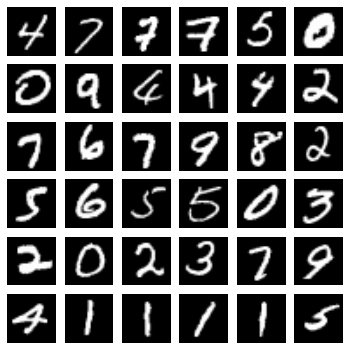

In [138]:
## Show Randomly picked Examples
def plot_sample(x, axis):
    img = x.reshape(28, 28)
    axis.imshow(img, cmap='gray')
    
fig = plt.figure(figsize=(6, 6))
for i in range(36):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    plot_sample(X[numpy.random.randint(0,60000)], ax)

# Neural Network with 1155044 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    1x28x28
  1  conv     5x26x26
  2  pool     5x13x13
  3  hidden1  854
  4  dropout  854
  5  hidden2  500
  6  output   10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       1.47357       2.34930      0.62724      0.09695  24.75s


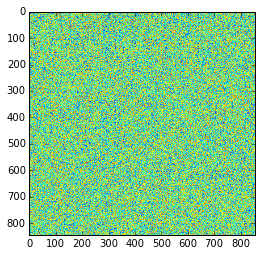

In [58]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

network = NeuralNet(
    #Define Layers
    layers=[
        ('input', layers.InputLayer),
        ('conv', layers.Conv2DLayer),
        ('pool', layers.MaxPool2DLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    #Hidden Unit Size, Activation Function
    input_shape=(None, 1, 28, 28),
    conv_num_filters=5, conv_filter_size=(3, 3), pool_pool_size=(2, 2),
    hidden1_num_units=854, hidden1_nonlinearity=nonlinearities.tanh,
    dropout_p = 0.5,
    hidden2_num_units=500,
    output_num_units=10, 
    output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    max_epochs=1,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
)

net = network.fit(X, y)
weights = network.get_all_params()
hidden1_weight = weights[2].get_value()
plt.imshow(hidden1_weight)

Cool!! however your research is not just simple classification/regression. You will need to implement your algorithm by yourself.

For example, following contents are **not** coverd in several libraries.
- **Layers**: Maxout Layer, Recurrent Layer, Word embeddings
- **Pretraining Strategies**: Pre-train network with different dataset
- **Transfer Learning**: Multiple Objective function
- **Customized Convolution**: k-max pooling
- **Different Cost function**: hinge loss, huber loss, cosine similarity

## Variables

In addition to numpy.ndarray, you need to know **Symbolic Variable** and **Shared Variable**.

- **Symbolic Variable** is a symbolic representation of quantities you want to use in functions. (Inputs)
- **Shared Variable** is a variable with **storage** that is shared between functions. (Weights)

In [7]:
import numpy
import theano
import theano.tensor as T

In [124]:
## Symbolic Variables 
a = T.iscalar("a")   # integer
b = T.fscalar("b")  # float scalar

x = T.fvector("x")  # float vector
X = T.fmatrix("X") # float matrix

## Shared Variable, store variables on cpu/gpu memory
W = theano.shared(numpy.array([0., 1., 2., 3., 4.]).astype("float32"), name="W")
bias  = theano.shared(numpy.float32(5), name="bias")

# Get Value from shared variable
print W.get_value() 

## Define symbolic graph
c = a + b
y = T.dot(x, W) + bias

## Print symbolic graph
print theano.pp(y)

##  Advanced:: You can replace some parts of compitation graph with different variable
d = theano.clone(output=c, replace={b: y}) #replace "b" with "y"
print theano.pp(d)

[ 0.  1.  2.  3.  4.]
((x \dot W) + bias)
(a + ((x \dot W) + bias))


## Function

Compile symbolic graph into a function

** BE CAREFUL**:: YOU NEED TO USE int32 or float32.

In [125]:
## Compile symbplic graph into a callable function
add = theano.function(inputs=[a, b], outputs=c)
linear = theano.function(inputs=[x], outputs=y)

## Call Functions
print add(1, 5)
print linear([0., 0., 0., 0., 1.]).astype("float32")

##Print function
theano.printing.debugprint(linear)

## Advanced :: You can evaluate symbolic graph without compilation
print c.eval({
                        a : numpy.int32(16), 
                         b : numpy.float32(12.10)
                     })

6.0
9.0
Elemwise{Add}[(0, 0)] [@A] ''   4
 |InplaceDimShuffle{} [@B] ''   3
 | |CGemv{inplace} [@C] ''   2
 |   |Alloc [@D] ''   1
 |   | |TensorConstant{0.0} [@E]
 |   | |TensorConstant{1} [@F]
 |   |TensorConstant{1.0} [@G]
 |   |InplaceDimShuffle{x,0} [@H] ''   0
 |   | |W [@I]
 |   |x [@J]
 |   |TensorConstant{0.0} [@E]
 |bias [@K]
28.1000003815


## Math

Most mathmatic operations are similar to numpy. However, comparison operations have special form. [Basics](http://deeplearning.net/software/theano/library/tensor/basic.html)

 Condition operation is represented by 
 ```python
 T.switch(condition, if true, if false)
 ```
 
 Comparison is represented by
 
 ```python
 T.gt(a, b) #Greater Than
 ```

In [8]:
x = T.fvector("x")

### Basic Math operation
exp_x = T.exp(x)
sigmoid_x = T.nnet.sigmoid(x)
tanh_x = T.tanh(x)

### Advanced:: condition and comparison
relu_x = T.switch(T.gt(x, 0), x, 0)

f = theano.function([x], [exp_x, sigmoid_x, tanh_x, relu_x])
f(numpy.array([-2., -1., 1., 2., 3.]).astype("float32"))

[array([  0.13533528,   0.36787945,   2.71828175,   7.38905621,  20.08553696], dtype=float32),
 array([ 0.11920292,  0.26894143,  0.7310586 ,  0.88079709,  0.95257413], dtype=float32),
 array([-0.96402758, -0.76159418,  0.76159418,  0.96402758,  0.99505478], dtype=float32),
 array([ 0.,  0.,  1.,  2.,  3.], dtype=float32)]

## Gradient (Automatic Differentiation)

You can define gradient symbolically. Amazing!!

In [197]:
# y = x ** 2
x = T.fscalar("x")
y = x ** 2
gy = theano.grad(cost=y, wrt=x) ## 2x

f = theano.function([x], [y, gy])
print f(10)

[array(100.0, dtype=float32), array(20.0, dtype=float32)]


Update parameters with gradient

**Since we have Autodiff, it's easy to change linear regression to non-linear regression.**

In [206]:
# Linar Regression
from collections import OrderedDict
rng = numpy.random.RandomState(1234)

##  Define Symbolic Variable
x, t = T.fvector("x"), T.fvector("t")

## Define Shared Variable
W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)), name="W")
b =  theano.shared(numpy.zeros(3), name="bias")

## Define graph
y = T.dot(x, W) + b
#y = T.nnet.sigmoid(T.dot(x, W) + b)
#y = T.tanh(T.dot(x, W) + b)
cost = T.sum((y - t)**2)

## Take gradient
gW, gb = T.grad(cost, [W, b])

## Set update expression in OrderedDict
updates =  OrderedDict({W: W-0.01*gW, bias: bias-0.01*gb}) #learning rate = 0.01

## Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)

## Lean!!
for epoch in range(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.113
epoch:: 2, cost:: 0.044
epoch:: 3, cost:: 0.017
epoch:: 4, cost:: 0.006


### GPU 

You don't need to know cuda. Just run your code with 
```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32, python your_code.py
```

If you want to use [cudnn](https://developer.nvidia.com/cudnn), you need to add one option
```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32, optimizer_including=cudnn, python your_code.py
```

If you have access to multiple gpus on your machine, you can specify which device you want to use.
```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu0,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu1,floatX=float32, python your_code.py
```

Let's check how fast your gpu

```bash
python numpy_knn.py
THEANO_FLAGS=mode=FAST_RUN,device=cpu,floatX=float32, python theano_knn.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32, python theano_knn.py
```

| MNIST (1-nearest neighbor) | F1@macro           | time |
| ------------- |:-------------:|:-------------:|
| Numpy          | 0.86  |  10.315 |
| Theano (cpu)  | 0.86  |   9.937 |
| Theano (gpu: Titan Black)  | 0.86  |   **4.627** |


In [5]:
#Load Data
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score

In [9]:
#K-Nearest Neighbor - use a label of the closest sample in training data as a prediction
X, y = mnist.data.astype("float32"), mnist.target.astype("int32")
X /= X.sum(axis=1)[:, numpy.newaxis]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_x = theano.shared(train_x)
valid_x = theano.shared(valid_x)

closest_sample = T.argmax(T.dot(valid_x, train_x.T), axis=1) #cosine similarity
f = theano.function([], closest_sample)

#Test
closest_sample = f()
pred = train_y[closest_sample]
f1 = f1_score(valid_y, pred, average='macro')
print "F1: %.3f"%(f1)

F1: 0.859


In [266]:
#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.function = function

        self.W = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype("float32"), name="W", )
        self.b =  theano.shared(numpy.zeros(out_dim).astype("float32"), name="bias")
        
        self.params = [ self.W, self.b ]

    def fprop(self, x):
        h = self.function(T.dot(x, self.W)+self.b)
        self.h = h
        return h 

class Convolution:
    def __init__(self, ):
        pass
    
class Maxpooling:
    def __init__(self, ):
        pass
    
class Recurrent:
    def __init__(self, ):
        pass

In [267]:
X, y = (mnist.data/255.0).astype("float32") , mnist.target.astype("int32")
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [270]:
x, t = T.fmatrix("x"), T.ivector("t")

layers = [
    Layer(784, 500, T.nnet.sigmoid),
    Layer(500, 500, T.nnet.sigmoid),
    Layer(500, 500, T.nnet.sigmoid),
    Layer(500, 10, T.nnet.softmax)
]

## Collect Parameters and Symbolic output
params = []
for i, layer in enumerate(layers):
    params += layer.params
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

## Cost Function (Negative Log Likelihood)
y = layers[-1].h
cost = - T.mean((T.log(y))[T.arange(x.shape[0]), t])

## Gradient
gparams = T.grad(cost, params)
gmomentums = [theano.shared(numpy.zeros_like(param.get_value(borrow=True)).astype("float32")) for param in params]
updates = OrderedDict()

## Defile Learning Rule, you can add Adagrad, Adadelta etc.
lr, momentum,  eps = 0.1, 0.9, 1e-6
for param, gparam, gmomentum, gsum in zip(params, gparams, gmomentums, gsums):
    #Clip gradient
    #gparam = theano.gradient.grad_clip(gparam, lower_bound=-5, upper_bound=5)

    # sgd
    #updates[param] = param + lr * updates[gmomentum]

    # momentum
    updates[gmomentum] = momentum * gmomentum - lr * gparam
    updates[param] = param + updates[gmomentum]

              
## Compile 
train = theano.function([x,t],cost,updates=updates)
test = theano.function([x,t],[cost, T.argmax(y, axis=1)])

## Iterate
batch_size = 100
nbatches = train_x.shape[0]//batch_size
for epoch in range(100):
    train_x, train_y = shuffle(train_x, train_y)  # Shuffle Samples
    for i in range(nbatches):
            start = i * batch_size
            end = start + batch_size
            train(train_x[start:end], train_y[start:end])
    valid_cost, pred = test(valid_x, valid_y)
    if epoch == 0 or epoch % 10 == 0:
        print "EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f"%(epoch, valid_cost, f1_score(valid_y, pred))

EPOCH:: 0, Validation cost: 0.596, Validation F1: 0.818
EPOCH:: 10, Validation cost: 0.106, Validation F1: 0.968
EPOCH:: 20, Validation cost: 0.081, Validation F1: 0.977
EPOCH:: 30, Validation cost: 0.092, Validation F1: 0.979
EPOCH:: 40, Validation cost: 0.096, Validation F1: 0.980
EPOCH:: 50, Validation cost: 0.100, Validation F1: 0.980
EPOCH:: 60, Validation cost: 0.103, Validation F1: 0.981
EPOCH:: 70, Validation cost: 0.106, Validation F1: 0.980
EPOCH:: 80, Validation cost: 0.108, Validation F1: 0.980
EPOCH:: 90, Validation cost: 0.109, Validation F1: 0.980


#### Exercise

1. Use Different Cost function, (Cross Entropy)
2. Implement ReLU
3. Add Dropout (Hint. add random term in fprop)
4. Add Learning rate adjuster (Hint. make learning rate as shared variable)
5. Try Different Convolution

### Something Wrong??

1. Check data type. You should use "int32", "float32".
2. Check matrix size
3. Check your graph is defined correctly (DisconnectedInputError, UnusedINputError)
4. Ask developers [Forum](https://groups.google.com/forum/#!forum/theano-users)
5. E-mail / Call me :)

## References
1. [Theano Documentation](http://deeplearning.net/software/theano/introduction.html)
2. F. Bastien, P. Lamblin, R. Pascanu, J. Bergstra, I. Goodfellow, A. Bergeron, N. Bouchard, D. Warde-Farley and Y. Bengio. [Theano: new features and speed improvements"](http://arxiv.org/pdf/1211.5590.pdf). NIPS 2012 deep learning workshop.
3. J. Bergstra, O. Breuleux, F. Bastien, P. Lamblin, R. Pascanu, G. Desjardins, J. Turian, D. Warde-Farley and Y. Bengio. [Theano: A CPU and GPU Math Expression Compiler](http://www.iro.umontreal.ca/~lisa/pointeurs/theano_scipy2010.pdf). Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX